# Tratamento dos dados raiz (para o  problema de machine Learning)

1.  Crowd Charge Transactions and GreenFlux Transactions data import.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns 
import matplotlib.pyplot as plt

file_path = 'C:/Users/Rodrigo Veiga/OneDrive/Doutorado/TarefasCarol/Artigos/DataSet/dados/CrowdCharge Transactions.xlsx'
file_path2 = 'C:/Users/Rodrigo Veiga/OneDrive/Doutorado/TarefasCarol/Artigos/DataSet/dados/GreenFlux Transactions.xlsx'
df = pd.read_excel(file_path)
dfgf = pd.read_excel(file_path2)

Data visualization (to avoid open excel everytime) 

Variable Specifications 

-   Transaction ID: added in the database to identify each transaction.  Also appears in the meter value data (i.e. to relate meter values to the transaction they relate to).  Transactions with ID beginning 2 are from a group of chargers where the match between charger and participant was unknown (due to errors in installations etc.).

-   ChargerID: identification number of the charger used
-   Participant ID: EN number for the participant linked to each charger.  Blank where participant ID is not known.
-   ParticipantCarkW: the rating of the participant’s vehicle, based on the ‘ChargerInstall’ data provided by DriveElectric
-   ParticipantCarkWh: the battery capacity of the participant’s vehicle, based on the ‘ChargerInstall’ data provided by DriveElectric
-   StartTime: plug-in time for the transaction, in UTC
-   StopTime: un-plug time for the transaction, in UTC.  N.B. these times do not equate to the time when charging started or ended.
-   Group ID: the group the charger belonged to for this transaction.  When chargers were not in the smart charging group they were not in a group and so the group ID is shown as NULL.
-   Trial: 1, 2 or 3 depending on which part of the trial applied to the group ID (for details of Trial 1, 2 and 3 see the final report).  When chargers were not in the smart charging group the Trial ID is NULL.  N.B. Events which took place during Trial 3 are likely to have been affected by the time of use incentive and so should be analysed separately.

-   Adjusted Start Time: Plug-in time in local time (i.e. equal to UTC when GMT applied, and adjusted to local time during British Summer Time).
-   Adjusted StopTime: as above, but for unplug time
-   PluggedInTime: the length of time the vehicle was plugged in, in minutes
-   ConsumedkWh: the energy transferred during the charging event, as recorded by the energy meter within the charger.  All records are included in the data.  Analysis for the Electric Nation report excluded events where less than 0.5kWh or more than 100kWh was consumed.

-   PartofManagedGroup: ‘Yes’ if the charger was in a smart charging group for this transaction.  N.B. this doesn’t mean the individual transaction was managed/curtailed.  No were GroupID or Trial is NULL.
-   Weekday or Weekend: If the vehicle was plugged in on a Monday – Friday then this shows ‘Weekday’.  If it was plugged in Saturday or Sunday, then Weekend.
-   ActiveChargingStart: the time when charging began, calculated using the meter value records (where these were available).  This is shown in local time only.  If it was not possible to calculate the start time (typically because the charger was offline so the meter value records were lost) then ‘NULL’ is shown.
-   MaxAmpsDrawnforT: the maximum current drawn for this transaction ID, at any point between the plug-in and plug-out times.
-   EndCharge: an estimate of the time when charging ended (as distinct from the time when the vehicle was unplugged).  This was calculated based on the meter value data (looking for sustained reductions in the current being drawn in the absence of demand management).  In some cases it may be inaccurate – this can be checked by calculating an equivalent charge rate and comparing to the rating of the charger.  For example, if ActiveChargingStart was 17:00 and EndCharge was 18:30, but 21kWh of energy was transferred then it’s likely that EndCharge is inaccurate (because it isn’t possible to add 21kWh in 1.5 hours using a 7kW charger).  NULL where is wasn’t possible to calculate this value (typically because meter values weren’t available).

-   ChargingDuration: time between ActiveChargingStart and EndCharge (if both values are available) in minutes
-   tInactiveStart: the number of minutes between plug-in and ActiveChargingStart.  Used to show whether or not a timer was used.
-   tInactiveEnd: the number of minutes between the end of charging and plug-out.  Used to show whether or not the event was hot unplugged.
-   UsedATimer: “Yes” where t active start is at least 30 minutes.  ‘No’ if t inactive start is less than 30 minutes.  NULL (unknown) if t inactive start is NULL.
-   BeganInWeekdayEveningPeak: NULL if ActiveChargingStart is NULL (time when charging began is unknown). ‘Yes’ if charging began between 16:00 and 19:59 on a weekday (Monday – Friday), otherwise ‘No’.
-   Hot Unplug:  Further details of the reasoning behind this logic is provided in Section 8.8 of the Final Customer Trial Report.
NULL if ActiveChargingStart is NULL.
‘No’ if t inactive end is greater than 15 minutes
‘Yes’ if ‘Used a Timer’ is ‘No’ and t inactive end is less than 15 minutes.
‘May be departure time’ if t inactive end is less than 15 minutes and ‘Used a Timer’ is ‘Yes’.
-   T1 Managed:
NULL if Trial is not 1 (i.e. this value is only populated for Trial 1)
‘Yes’ if the transaction was constrained at some point during charging
‘No’ if it was not.  Transactions which took place when the charger was offline (where meter values are not available so quantities such as ActiveChargingStart are NULL) were not managed, so these are shown as ‘No’.
-   T2 Managed (N.B. all Trial 3 were effectively ‘managed’ because of the CrowdCharge algorithm used alongside the ToU tariff, therefore there are no T3 Managed columns): 
NULL if Trial is not 2 (i.e. this value is only populated for Trial 2)
‘Yes’ if the transaction was constrained at some point during charging
‘No’ if it was not.  Transactions which took place when the charger was offline (where meter values are not available so quantities such as ActiveChargingStart are NULL) were not managed, so these are shown as ‘No’.
-   Restriction T1: calculated using the methodology set out in Section 10.1.4 of the Final Customer Trial Report:
Blank if the transaction did not occur in Trial 1, or it fails any of the criteria set out on Page 238 to 239 of the final report.
Otherwise, equal to 1 – (Theoretical Minimum Charging Time/ Actual Charging Time)
-   Restriction T2: calculated using the methodology set out in Section 10.1.4 of the Final Customer Trial Report:
Blank if the transaction did not occur in Trial 2, or it fails any of the criteria set out on Page 238 to 239 of the final report.
Otherwise, equal to 1 – (Theoretical Minimum Charging Time/ Actual Charging Time)

In [38]:
dfgf.head()

,TransactionID,ChargerID,ParticipantID,ParticipantCarkW,ParticipantCarkWh,StartTime,StopTime,GroupID,Trial,AdjustedStartTime,AdjustedStopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ActiveChargingStart,EndCharge,ChargingDuration,HotUnplug,Managed
0,1,UK-GFX-ENA0001,EN1073,7.0,33.0,2017-01-12 15:21:00,2017-01-12 15:23:00,NaN,NaN,2017-01-12 15:21:00,2017-01-12 15:23:00,2,0.0,Weekday,NaT,NaT,NaN,NaN,NaN
1,2,UK-GFX-ENA0001,EN1073,7.0,33.0,2017-01-17 09:46:00,2017-01-17 09:51:00,NaN,NaN,2017-01-17 09:46:00,2017-01-17 09:51:00,5,0.2,Weekday,NaT,NaT,NaN,NaN,NaN
2,3,UK-GFX-ENA0009,EN1116,7.0,33.0,2017-01-24 13:51:00,2017-01-24 13:52:00,NaN,NaN,2017-01-24 13:51:00,2017-01-24 13:52:00,1,0.0,Weekday,NaT,NaT,NaN,NaN,NaN
3,4,UK-GFX-ENA0010,EN1083,7.0,33.0,2017-01-24 14:16:00,2017-01-24 14:17:00,NaN,NaN,2017-01-24 14:16:00,2017-01-24 14:17:00,1,0.0,Weekday,NaT,NaT,NaN,NaN,NaN
4,5,UK-GFX-ENA0014,EN1018,3.6,9.9,2017-01-25 07:37:00,2017-01-25 07:38:00,NaN,NaN,2017-01-25 07:37:00,2017-01-25 07:38:00,1,0.0,Weekday,NaT,NaT,NaN,NaN,NaN


In [39]:
df.head()

,TransactionID,ChargerID,ParticipantID,CarKW,CarKWh,StartTime,StopTime,Trial,AdjustedStartTime,AdjustedStopTime,PluggedInTime,ConsumedkWh,Weekday_or_Weekend,Max_Current_Drawn_for_T,EndCharge,ChargingDuration,t_inactive_start,t_inactive_end,Used_a_Timer,Hot_Unplug
0,100000,36002417,EN1012,7.0,24.0,2017-03-08 17:50:00,2017-03-08 20:54:00,NaN,2017-03-08 17:50:00,2017-03-08 20:54:00,184,13.74,Weekday,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,100001,36002417,EN1012,7.0,24.0,2017-03-12 00:06:00,2017-03-12 10:36:00,NaN,2017-03-12 00:06:00,2017-03-12 10:36:00,630,13.83,Weekend,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,100002,36002417,EN1012,7.0,24.0,2017-03-15 00:10:00,2017-03-15 08:48:00,NaN,2017-03-15 00:10:00,2017-03-15 08:48:00,518,16.92,Weekday,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,100003,36002417,EN1012,7.0,24.0,2017-03-24 16:40:00,2017-03-24 19:45:00,NaN,2017-03-24 16:40:00,2017-03-24 19:45:00,185,13.54,Weekday,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,100004,36002417,EN1012,7.0,24.0,2017-03-24 20:23:00,2017-03-25 08:05:00,NaN,2017-03-24 20:23:00,2017-03-25 08:05:00,702,2.54,Weekday,NaN,2017-03-25 06:41:00,139.0,479.0,84.0,Yes,No


Get the number of missing data points per column 

In [40]:
missing_values_count_df = df.isnull().sum()
missing_values_count_dfgf = dfgf.isnull().sum()


In [41]:
missing_values_count_df[0:20]


TransactionID                  0
ChargerID                      0
ParticipantID               3899
CarKW                       3899
CarKWh                      3899
StartTime                      0
StopTime                       0
Trial                      24034
AdjustedStartTime              0
AdjustedStopTime               0
PluggedInTime                  0
ConsumedkWh                    1
Weekday_or_Weekend             0
Max_Current_Drawn_for_T    35520
EndCharge                  20855
ChargingDuration           20861
t_inactive_start           19707
t_inactive_end             20855
Used_a_Timer               19707
Hot_Unplug                 19839
dtype: int64

In [42]:
missing_values_count_dfgf[0:20]

TransactionID              0
ChargerID                  0
ParticipantID              0
ParticipantCarkW           0
ParticipantCarkWh          0
StartTime                  0
StopTime                   0
GroupID                29569
Trial                  29569
AdjustedStartTime          0
AdjustedStopTime           0
PluggedInTime              0
ConsumedkWh                0
WeekdayOrWeekend           0
ActiveChargingStart    24709
EndCharge              28122
ChargingDuration       28207
HotUnplug              28122
Managed                45909
dtype: int64

How many total missing values we have?

In [43]:
total_cells = np.product(df.shape)
total_missing = missing_values_count_df.sum()

Percent of data that is missing 

In [44]:
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

13.546531207903008


13,54% data is missing. Is this value missing because it wasn't recorded or because it doesn't exist? If the value doesn't exist its not possibly to guess about it. On the other hand, if a value is missing because it wasn't recorded, then we have to guess it using the other values in that column and row. (IMPUTATION)

I'm hurry and we have only 13,54 of missing data. An option I have is to just remove rows or columns that contain missing values. 
Below removing all the rows that contain a missing value

In [45]:
df.dropna()

,TransactionID,ChargerID,ParticipantID,CarKW,CarKWh,StartTime,StopTime,Trial,AdjustedStartTime,AdjustedStopTime,PluggedInTime,ConsumedkWh,Weekday_or_Weekend,Max_Current_Drawn_for_T,EndCharge,ChargingDuration,t_inactive_start,t_inactive_end,Used_a_Timer,Hot_Unplug
13,100013,36002417,EN1012,7.0,24.0,2017-09-04 17:29:00,2017-09-04 20:09:00,1.0,2017-09-04 18:29:00,2017-09-04 21:09:00,160,14.41,Weekday,1900-01-28 07:12:00,2017-09-04 21:05:00,155.0,1.0,4.0,No,Yes
14,100014,36002417,EN1012,7.0,24.0,2017-09-05 21:07:00,2017-09-06 07:06:00,1.0,2017-09-05 22:07:00,2017-09-06 08:06:00,599,20.97,Weekday,1900-01-27 20:38:24,2017-09-06 01:29:00,201.0,1.0,397.0,No,No
15,100015,36002417,EN1012,7.0,24.0,2017-09-06 21:40:00,2017-09-07 06:38:00,1.0,2017-09-06 22:40:00,2017-09-07 07:38:00,538,13.99,Weekday,1900-01-27 14:24:00,2017-09-07 01:08:00,147.0,1.0,390.0,No,No
16,100016,36002417,EN1012,7.0,24.0,2017-09-17 16:02:00,2017-09-18 06:56:00,1.0,2017-09-17 17:02:00,2017-09-18 07:56:00,894,15.60,Weekend,1900-01-28 14:24:00,2017-09-17 19:40:00,157.0,1.0,736.0,No,No
17,100017,36002417,EN1012,7.0,24.0,2017-09-26 21:01:00,2017-09-27 06:31:00,1.0,2017-09-26 22:01:00,2017-09-27 07:31:00,570,15.86,Weekday,1900-01-27 20:52:48,2017-09-27 00:50:00,168.0,1.0,401.0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67328,166177,568004118,EN1954,3.6,7.6,2018-11-07 21:25:00,2018-11-08 07:52:00,2.0,2018-11-07 21:25:00,2018-11-08 07:52:00,627,6.97,Weekday,1900-01-15 11:02:24,2018-11-07 23:06:00,100.0,1.0,526.0,No,No
67329,166178,568004118,EN1954,3.6,7.6,2018-11-08 18:33:00,2018-11-09 07:55:00,2.0,2018-11-08 18:33:00,2018-11-09 07:55:00,802,7.39,Weekday,1900-01-15 15:21:36,2018-11-08 20:22:00,108.0,1.0,693.0,No,No
67330,166179,568004118,EN1954,3.6,7.6,2018-11-10 00:43:00,2018-11-10 19:02:00,2.0,2018-11-10 00:43:00,2018-11-10 19:02:00,1099,7.61,Weekend,1900-01-15 05:45:36,2018-11-10 02:31:00,107.0,1.0,991.0,No,No
67331,166180,568004118,EN1954,3.6,7.6,2018-11-10 21:57:00,2018-11-12 07:33:00,2.0,2018-11-10 21:57:00,2018-11-12 07:33:00,2016,7.43,Weekend,1900-01-15 12:43:12,2018-11-10 23:38:00,100.0,1.0,1915.0,No,No


In [46]:
dfgf.dropna()

,TransactionID,ChargerID,ParticipantID,ParticipantCarkW,ParticipantCarkWh,StartTime,StopTime,GroupID,Trial,AdjustedStartTime,AdjustedStopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ActiveChargingStart,EndCharge,ChargingDuration,HotUnplug,Managed
5608,5609,UK-GFX-ENA0019,EN1043,3.6,12.0,2017-07-11 12:20:00,2017-07-12 04:55:00,GF0001,1.0,2017-07-11 13:20:00,2017-07-12 05:55:00,995,9.6,Weekday,2017-07-12 01:00:00,2017-07-12 04:14:59,194.0,No,No
5609,5610,UK-GFX-ENA0039,EN1086,7.0,22.0,2017-07-11 16:40:00,2017-07-11 18:07:00,GF0001,1.0,2017-07-11 17:40:00,2017-07-11 19:07:00,87,4.5,Weekday,2017-07-11 17:45:00,2017-07-11 19:07:00,82.0,Yes,No
5621,5622,UK-GFX-ENA0003,EN1112,3.6,8.8,2017-07-11 16:37:00,2017-07-12 15:23:00,GF0001,1.0,2017-07-11 17:37:00,2017-07-12 16:23:00,1366,7.3,Weekday,2017-07-11 17:45:00,2017-07-11 19:59:59,134.0,No,No
5622,5623,UK-GFX-ENA0009,EN1116,7.0,33.0,2017-07-11 21:26:00,2017-07-12 06:51:00,GF0001,1.0,2017-07-11 22:26:00,2017-07-12 07:51:00,565,16.8,Weekday,2017-07-11 22:30:00,2017-07-12 01:14:59,164.0,No,No
5623,5624,UK-GFX-ENA0009,EN1116,7.0,33.0,2017-07-12 07:00:00,2017-07-12 08:29:00,GF0001,1.0,2017-07-12 08:00:00,2017-07-12 09:29:00,89,1.5,Weekday,2017-07-12 08:00:00,2017-07-12 08:44:59,44.0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84649,84902,UK-GFX-ENA0014,EN1018,3.6,9.9,2018-12-15 20:11:00,2018-12-18 08:18:00,GFTariffsPilot02,3.0,2018-12-15 20:11:00,2018-12-18 08:18:00,3607,9.7,Weekend,2018-12-15 22:00:00,2018-12-16 00:29:00,149.0,No,No
84713,84966,UK-GFX-ENA0310,EN1483,3.6,12.0,2018-12-16 14:50:00,2018-12-18 15:37:00,GFTariffsPilot02,3.0,2018-12-16 14:50:00,2018-12-18 15:37:00,2927,2.8,Weekend,2018-12-16 15:00:00,2018-12-16 16:14:00,74.0,No,No
84841,85094,UK-GFX-ENA0330,EN1459,3.6,7.1,2018-12-12 21:10:00,2018-12-19 09:58:00,GFTariffsPilot02,3.0,2018-12-12 21:10:00,2018-12-19 09:58:00,9408,2.5,Weekday,2018-12-15 22:15:00,2018-12-15 22:44:00,29.0,No,No
85232,85485,UK-GFX-ENA0322,EN1567,3.6,4.4,2018-12-16 16:09:00,2018-12-21 18:54:00,GFTariffsPilot02,3.0,2018-12-16 16:09:00,2018-12-21 18:54:00,7365,3.5,Weekend,2018-12-16 16:45:00,2018-12-16 17:29:00,44.0,No,No


In [25]:
df.dropna().head()

,TransactionID,ChargerID,ParticipantID,CarKW,CarKWh,StartTime,StopTime,Trial,AdjustedStartTime,AdjustedStopTime,PluggedInTime,ConsumedkWh,Weekday_or_Weekend,Max_Current_Drawn_for_T,EndCharge,ChargingDuration,t_inactive_start,t_inactive_end,Used_a_Timer,Hot_Unplug
13,100013,36002417,EN1012,7.0,24.0,2017-09-04 17:29:00,2017-09-04 20:09:00,1.0,2017-09-04 18:29:00,2017-09-04 21:09:00,160,14.41,Weekday,1900-01-28 07:12:00,2017-09-04 21:05:00,155.0,1.0,4.0,No,Yes
14,100014,36002417,EN1012,7.0,24.0,2017-09-05 21:07:00,2017-09-06 07:06:00,1.0,2017-09-05 22:07:00,2017-09-06 08:06:00,599,20.97,Weekday,1900-01-27 20:38:24,2017-09-06 01:29:00,201.0,1.0,397.0,No,No
15,100015,36002417,EN1012,7.0,24.0,2017-09-06 21:40:00,2017-09-07 06:38:00,1.0,2017-09-06 22:40:00,2017-09-07 07:38:00,538,13.99,Weekday,1900-01-27 14:24:00,2017-09-07 01:08:00,147.0,1.0,390.0,No,No
16,100016,36002417,EN1012,7.0,24.0,2017-09-17 16:02:00,2017-09-18 06:56:00,1.0,2017-09-17 17:02:00,2017-09-18 07:56:00,894,15.60,Weekend,1900-01-28 14:24:00,2017-09-17 19:40:00,157.0,1.0,736.0,No,No
17,100017,36002417,EN1012,7.0,24.0,2017-09-26 21:01:00,2017-09-27 06:31:00,1.0,2017-09-26 22:01:00,2017-09-27 07:31:00,570,15.86,Weekday,1900-01-27 20:52:48,2017-09-27 00:50:00,168.0,1.0,401.0,No,No


In [24]:
df.shape
df.dropna().shape

(35744, 20)

In [21]:
tamanhodatanotfiltered = np.product(df.shape)
tamanhofiltered = np.product(df.dropna().shape)
print(tamanhodatanotfiltered)
print(tamanhofiltered)
print(f'Percentage of cells deleted was {100*(1 - tamanhofiltered/tamanhodatanotfiltered)}%')

1425280
714880
A porcentagem de células perdidas foi de 49.84283789851819%


In [47]:
dfgf.dropna().head()

,TransactionID,ChargerID,ParticipantID,ParticipantCarkW,ParticipantCarkWh,StartTime,StopTime,GroupID,Trial,AdjustedStartTime,AdjustedStopTime,PluggedInTime,ConsumedkWh,WeekdayOrWeekend,ActiveChargingStart,EndCharge,ChargingDuration,HotUnplug,Managed
5608,5609,UK-GFX-ENA0019,EN1043,3.6,12.0,2017-07-11 12:20:00,2017-07-12 04:55:00,GF0001,1.0,2017-07-11 13:20:00,2017-07-12 05:55:00,995,9.6,Weekday,2017-07-12 01:00:00,2017-07-12 04:14:59,194.0,No,No
5609,5610,UK-GFX-ENA0039,EN1086,7.0,22.0,2017-07-11 16:40:00,2017-07-11 18:07:00,GF0001,1.0,2017-07-11 17:40:00,2017-07-11 19:07:00,87,4.5,Weekday,2017-07-11 17:45:00,2017-07-11 19:07:00,82.0,Yes,No
5621,5622,UK-GFX-ENA0003,EN1112,3.6,8.8,2017-07-11 16:37:00,2017-07-12 15:23:00,GF0001,1.0,2017-07-11 17:37:00,2017-07-12 16:23:00,1366,7.3,Weekday,2017-07-11 17:45:00,2017-07-11 19:59:59,134.0,No,No
5622,5623,UK-GFX-ENA0009,EN1116,7.0,33.0,2017-07-11 21:26:00,2017-07-12 06:51:00,GF0001,1.0,2017-07-11 22:26:00,2017-07-12 07:51:00,565,16.8,Weekday,2017-07-11 22:30:00,2017-07-12 01:14:59,164.0,No,No
5623,5624,UK-GFX-ENA0009,EN1116,7.0,33.0,2017-07-12 07:00:00,2017-07-12 08:29:00,GF0001,1.0,2017-07-12 08:00:00,2017-07-12 09:29:00,89,1.5,Weekday,2017-07-12 08:00:00,2017-07-12 08:44:59,44.0,No,No


All null cells deleted from both Crowd Charge and GreenFlux Transactions Data

2. Tratando dados no formato datetime 

Variáveis no formato datetime que serão tratadas
1 -> StartTime
2 -> StopTime
3 -> AdjustedStartTime
4 -> AdjustedStopTime

In [3]:
StartTime = df.StartTime
StopTime = df.StopTime
AdjustedStartTime = df.AdjustedStartTime
AdjustedStopTime = df.AdjustedStopTime
t_inactive_start = df.t_inactive_start

In [4]:
StartTime2float = []
StopTime2float = []
AdjStartTime2float = []
AdjStopTime2float = []

In [5]:
for i in range(len(StartTime)):
    
    StartTime2float =  np.append(StartTime2float,StartTime[i].hour + (StartTime[i].minute)/60)
    
    StopTime2float = np.append(StopTime2float, StopTime[i].hour + (StopTime[i].minute)/60 )
    
    AdjStartTime2float = np.append(AdjStartTime2float, StopTime[i].hour + (AdjustedStartTime[i].minute)/60 )
    
    AdjStopTime2float = np.append(AdjStopTime2float, StopTime[i].hour + (AdjustedStopTime[i].minute)/60 )

Plot das Variáveis datetime no formato de histograma. O objetivo aqui é determinar a função densidade de probabilidade que melhor representa cada uma das variáveis.

Plot da Variável StartTime

Text(0, 0.5, 'Densidade de Probabilidade')

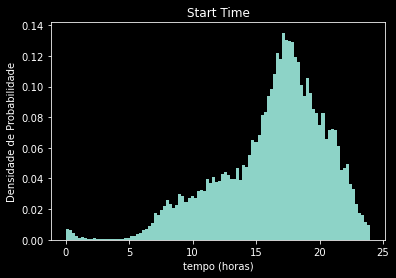

In [6]:
plt.Figure()
plt.hist(StartTime2float, density = True, bins = 100)
plt.xlabel('tempo (horas)')
plt.title('Start Time')
plt.ylabel('Densidade de Probabilidade')

Plot da Variável StopTime

Text(0.5, 1.0, 'Stop Time')

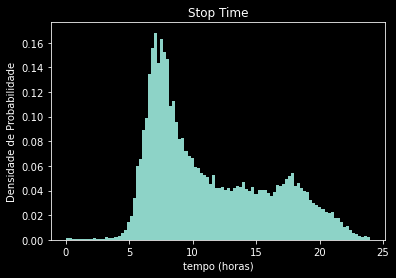

In [7]:
plt.Figure()
plt.hist(StopTime2float, density = True, bins = 100)
plt.xlabel('tempo (horas)')
plt.ylabel('Densidade de Probabilidade')
plt.title('Stop Time')


Text(0.5, 1.0, 'Adjusted Start Time')

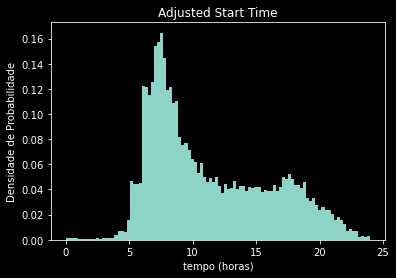

In [8]:
plt.Figure()
plt.hist(AdjStartTime2float, density = True, bins = 100)
plt.xlabel('tempo (horas)')
plt.ylabel('Densidade de Probabilidade')
plt.title('Adjusted Start Time')

Text(0.5, 1.0, 'Adjusted Stop Time')

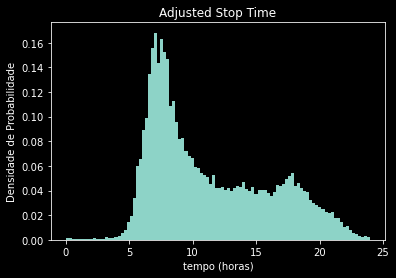

In [9]:
plt.Figure()
plt.hist(AdjStopTime2float, density = True, bins = 100)
plt.xlabel('tempo (horas)')
plt.ylabel('Densidade de Probabilidade')
plt.title('Adjusted Stop Time')
